-   How can I parallelize computations on rasters with Dask?
-   How can I determine if parallelization improves calculation speed?
-   What are good practices in applying parallelization to my raster calculations?

-   Profile the timing of the raster calculations.
-   Open raster data as a chunked array.
-   Recognize good practices in selecting proper chunk sizes.
-   Setup raster calculations that take advantage of parallelization.

## Introduction

Very often raster computations involve applying the same operation to different pieces of data. Think, for instance, to
the “pixel”-wise sum of two raster datasets, where the same sum operation is applied to all the matching grid-cells of
the two rasters. This class of tasks can benefit from chunking the input raster(s) into smaller pieces: operations on
different pieces can be run in parallel using multiple computing units (e.g., multi-core CPUs), thus potentially
speeding up calculations. In addition, working on chunked data can lead to smaller memory footprints, since one
may bypass the need to store the full dataset in memory by processing it chunk by chunk.

In this episode, we will introduce the use of Dask in the context of raster calculations. Dask is a Python library for
parallel and distributed computing. It provides a framework to work with different data structures, including chunked
arrays (Dask Arrays). Dask is well integrated with (`rio`)`xarray`, which can use Dask arrays as underlying
data structures.

It is important to realize, however, that many details determine the extent to which using Dask’s chunked arrays instead
of regular Numpy arrays leads to faster calculations (and lower memory requirements). The actual operations to carry
out, the size of the dataset, and parameters such as the chunks’ shape and size, all affects the performance of our
computations. Depending on the specifics of the calculations, serial calculations might actually turn out to be faster!
Being able to profile the computational time is thus essential, and we will see how to do that in a Jupyter environment
in the next section.

The example that we consider here is the application of a median filter to a raster digital elevation model (DEM).
[Median filtering](https://en.wikipedia.org/wiki/Median_filter) is a common noise removal, which "smoothen" a raster by
replacing a pixel’s value with the median value computed from its surrounding pixels. It can be seen as an example of a
focal statistics, where for each pixel you compute a statistics (the median) over a set of neighbouring cells. We apply
median filtering to the DEM in order to improve it for the calculation of slope.


## A smoother DEM

Let's open the raster DEM file of Rhodes, masking out missing values and dropping the (single valued) band dimension using the `squeeze` method:

In [1]:
import rioxarray
dem = rioxarray.open_rasterio('dem_combined_reprojected.tif', masked=True)
dem = dem.squeeze()

Let’s make sure the data has been loaded into memory before proceeding to time profile our raster calculation. Calling
the `.load()` method of a DataArray object triggers data loading:

In [2]:
dem = dem.load()

Note that by default data is loaded using Numpy arrays as underlying data structure. We can visualize the raster:

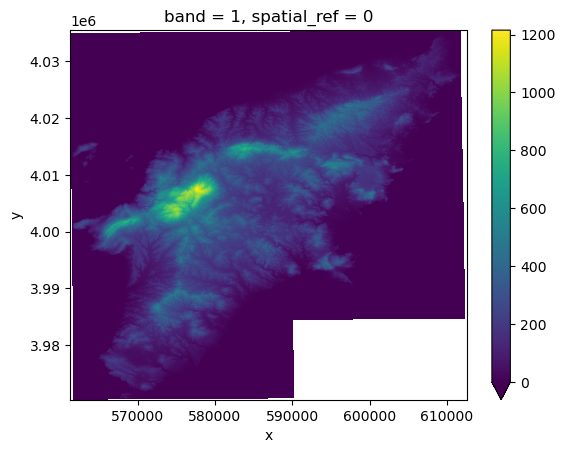

In [3]:
dem.plot.imshow(cmap='viridis', vmin=0)

The DEM is not perfect, since we can find negative values:

In [4]:
dem.min()

<xarray.DataArray ()>
array(-2.5352883, dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

Also, it has a reasonably high resolution (30m), which is good if we need to explore detailed features of an area. However, if we want to compute a derived quantity such as the slope of the terrain, or if we want to visualize contour lines connecting points at similar heights, we might want to increase the smoothness of the DEM.  

In [5]:
# show the DEM resolution
dem.rio.resolution()

(30.0, -30.0)

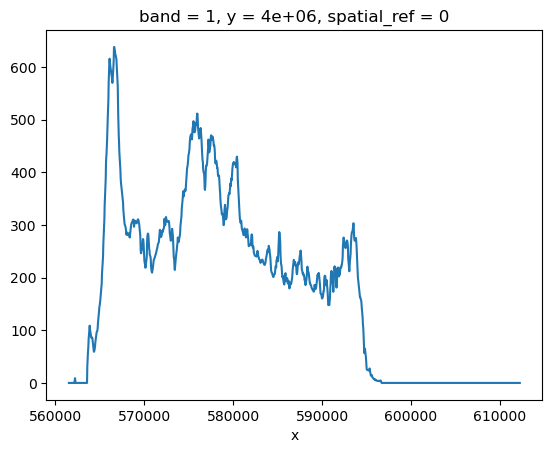

In [6]:
# plot a 1D cut through the DEM: quite a lot of features!
dem.sel(y=4_000_000, method='nearest').plot()

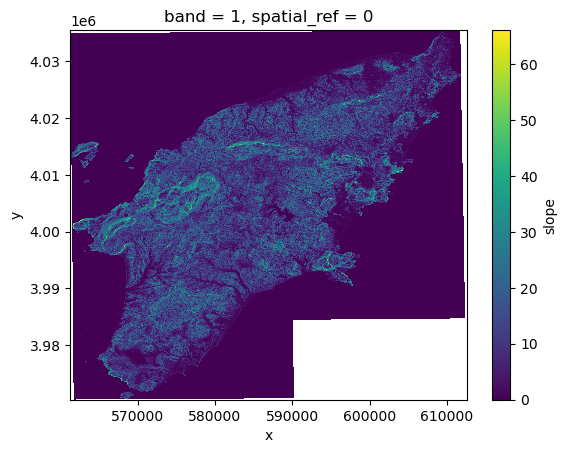

In [7]:
# let's calculate the slope from the DEM, and visualize it
import xrspatial
slope = xrspatial.slope(dem)
slope.plot.imshow()

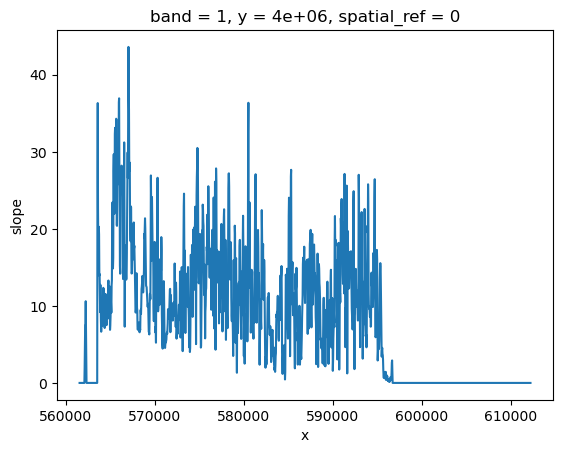

In [8]:
# again, the 1D cut shows the noise in the derived slope
slope.sel(y=4_000_000, method='nearest').plot()

Let’s now apply a median filter to the dem while keeping track of the execution time of this task. The filter is
carried out in two steps: first, we define the size and centering of the region around each pixel that will be
considered for the median calculation (the so-called “windows”), using the `.rolling()` method. We choose here windows
that are 9 pixel wide in both x and y dimensions, and, for each window, consider the central pixel as the window target.
We then call the `.median()` method, which initiates the construction of the windows and the actual calculation.

For the time profiling, we make use of the Jupyter magic `%%time`, which returns the time required to run the content
of a cell (note that commands starting with `%%` needs to be on the first line of the cell!):

In [9]:
%%time
dem_smooth = dem.rolling(x=9, y=9, center=True).median()

CPU times: user 14.8 s, sys: 4.45 s, total: 19.2 s
Wall time: 20 s


Let’s note down the calculation’s “Wall time” (actual time to perform the task). We can inspect the image resulting
after the application of median filtering:

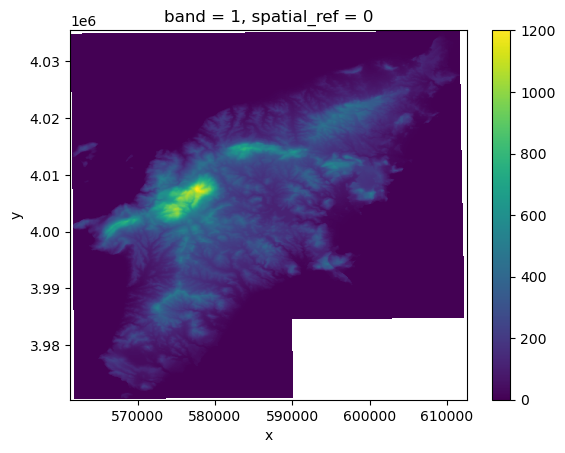

In [10]:
dem_smooth.plot.imshow()

In [11]:
# the "artificial" negative values have disappeared
dem_smooth.min()

<xarray.DataArray ()>
array(0., dtype=float32)
Coordinates:
    band         int64 1
    spatial_ref  int64 0

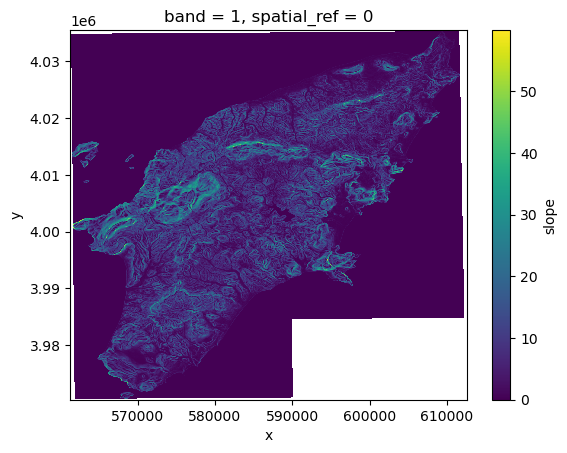

In [12]:
# at a glance, we see that the smoothness of the slope is also increased
slope_smooth = xrspatial.slope(dem_smooth)
slope_smooth.plot.imshow()

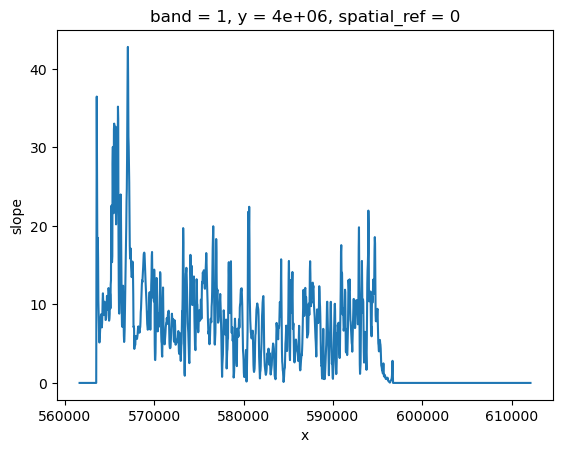

In [13]:
# we see it even more in the 1D cut
slope_smooth.sel(y=4_000_000, method='nearest').plot()

## Handling edges

By looking closely, you might notice a tiny white edge at the plot boundaries. These are the pixels that are less than
4 pixels away from the border of the image. These pixels cannot be surrounded by a 9 pixel wide window. The default
behaviour is to assign these with nodata values.

Finally, let’s convert the slope from degrees to percentage and write the data to disk:

In [43]:
np.tan(np.radians(slope_smooth)).rio.to_raster('slope.tif', driver='COG')

In the following section we will see how to parallelize these raster calculations, and we will compare timings to the
serial calculations that we have just run.

## Dask-powered rasters

### Chunked arrays

As we have mentioned, `rioxarray` supports the use of Dask’s chunked arrays as underlying data structure. When opening
a raster file with `open_rasterio` and providing the `chunks` argument, Dask arrays are employed instead of regular
Numpy arrays. `chunks` describes the shape of the blocks which the data will be split in. As an example, we
open the red band raster using a chunk shape of `(1, 4000, 4000)` (block size of `1` in the first dimension and
of `4000` in the second and third dimensions):

In [15]:
red = rioxarray.open_rasterio('red.tif', chunks=(1, 4000, 4000))

Xarray and Dask also provide a graphical representation of the raster data array and of its blocked structure.

### Exercise: Chunk sizes matter

We have already seen how COGs are regular GeoTIFF files with a special internal structure. other feature of COGs is
that data is organized in “blocks” that can be accessed remotely via independent HTTP requests, abling partial file
readings. This is useful if you want to access only a portion of your raster file, but it also lows for efficient
parallel reading. You can check the blocksize employed in a COG file with the following code ippet:

```python
import rasterio
with rasterio.open('/path/or/URL/to/file.tif') as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")
```
In order to optimally access COGs it is best to align the blocksize of the file with the chunks ployed when loading
the file. Open the blue-band asset (the “blue” asset) of a Sentinel-2 scene as a chunked `DataArray` object using a suitable
chunk size. Which elements do you think should be considered when choosing the chunk size?

### Solution

In [16]:
import rasterio
with rasterio.open('red.tif') as r:
    if r.is_tiled:
        print(f"Chunk size: {r.block_shapes}")

Chunk size: [(512, 512)]


Ideal chunk size values for this raster are thus multiples of 512. An element to consider is number of
resulting chunks and their size. While the optimal chunk size strongly depends on the specific application, chunks
should in general not be too big nor too small (i.e. too many). As a rule of thumb, chunk sizes of 100 MB typically
work well with Dask (see, e.g., this [blog post](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes)). Also,
the shape might be relevant, depending on the application! Here, we might select a chunks shape of
`(1, 6144, 6144)`::

In [17]:
red = rioxarray.open_rasterio('red.tif', chunks=(1, 6144, 6144))

which leads to chunks 72 MB large: ((1 x 6144 x 6144) x 2 bytes / 2^20 = 72 MB). Also, we can let rioxarray and Dask figure out appropriate chunk shapes by setting`chunks=“auto”`:

In [18]:
red = rioxarray.open_rasterio('red.tif', chunks='auto')

which leads to `(1, 8192, 8192)` chunks (128 MB).

### Parallel computations

Operations performed on a `DataArray` that has been opened as a chunked Dask array are executed using Dask. Dask
coordinates how the operations should be executed on the individual chunks of data, and runs these tasks in parallel as
much as possible.

Let’s now repeat the raster calculations that we have carried out in the previous section, but running calculations in
parallel over a multi-core CPU. We first open the relevant rasters as chunked arrays:

In [44]:
dem_dask = rioxarray.open_rasterio('dem_combined_reprojected.tif', lock=False, chunks=(1, 1024, 1024))

Setting `lock=False` tells `rioxarray` that the individual data chunks can be loaded simultaneously from the source by
the Dask workers.

As the next step, we trigger the (down)load of the data using the `.persist()` method, see below. This makes sure that
the loaded chunks are stored in the form of a chunked Dask array (calling `.load()` would instead merge the chunks
in a single Numpy array).

We explicitly tell Dask to parallelize the required workload over 4 threads:

In [45]:
dem_dask = dem_dask.persist(scheduler="threads", num_workers=4)

Let’s now continue to the actual calculation. Note how the same syntax as for its serial version is employed for
applying the median filter. Don’t forget to add the Jupyter magic to record the timing!

In [46]:
dem_dask = dem_dask.squeeze()

In [47]:
%%time
dem_smooth_dask = dem_dask.rolling(x=9, y=9, center=True).median()

CPU times: user 16.7 ms, sys: 1.48 ms, total: 18.2 ms
Wall time: 17.2 ms


Did we just observe a 700x speed-up when comparing to the serial calculation (~20 s vs ~25 ms)? Actually, no
calculation has run yet. This is because operations performed on Dask arrays are executed “lazily”, i.e. they are not
immediately run.

### Dask graph

The sequence of operations to carry out is stored in a task graph, which can be visualized with:

In [48]:
import dask
dask.visualize(dem_smooth_dask)

The task graph gives Dask the complete “overview” of the calculation, thus enabling a better nagement of tasks and
resources when dispatching calculations to be run in parallel.

Most methods of `DataArray`’s run operations lazily when Dask arrays are employed. In order to trigger calculations, we
can use either `.persist()` or `.compute()`. The former keeps data in the form of chunked Dask arrays, and it should
thus be used to run intermediate steps that will be followed by additional calculations. The latter merges instead the
chunks in a single Numpy array, and it should be used at the very end of a sequence of calculations. Both methods
accept the same parameters (here, we again explicitly tell Dask to run tasks on 4 threads). Let’s again time the cell
execution:

In [49]:
%%time
dem_smooth_dask = dem_smooth_dask.persist(scheduler="threads", num_workers=4)

/opt/miniconda3/envs/geospatial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


CPU times: user 20.7 s, sys: 6.4 s, total: 27.1 s
Wall time: 8.59 s


The timing that we have recorded makes much more sense now. When running the task on a 4-core CPU laptop, we observe a
x3 speed-up when comparing to the analogous serial calculation (~20 s s vs ~7 s).

Once again, we stress that one does not always obtain similar performance gains by exploiting the Dask-based
parallelization. Even if the algorithm employed is well suited for parallelization, Dask introduces some overhead time
to manage the tasks in the Dask graph. This overhead, which is typically of the order of few milliseconds per task, can
be larger than the parallelization gain. This is the typical situation with calculations with many small chunks.

We now calculate the slope using the slope function from Xarray spatial and convert the result into a percentage. 
Note that not all functions working with rasters support parallel calculations, some of them have to "realize" the data in memory!

In [50]:
slope_dask = xrspatial.slope(dem_smooth_dask)
slope_dask = np.tan(np.radians(slope_dask))
slope_dask = slope_dask.persist(scheduler="threads", num_workers=4)

Finally, let’s have a look at how Dask can be used to save raster files. When calling `.to_raster()`, we provide the
additional argument `lock=threading.Lock()`: the threads which are splitting the workload must “synchronise” when writing to the same file
(they might otherwise overwrite each other’s output).

In [51]:
from threading import Lock
slope_dask.rio.to_raster('slope_dask.tif', driver='COG', lock=Lock())

Note that `.to_raster()` is among the methods that trigger immediate calculations (one can change this behaviour by
specifying `compute=False`)

-   The `%%time` Jupyter magic command can be used to profile calculations.
-   Data ‘chunks’ are the unit of parallelization in raster calculations.
-   (`rio`)`xarray` can open raster files as chunked arrays.
-   The chunk shape and size can significantly affect the calculation performance.
-   Cloud-optimized GeoTIFFs have an internal structure that enables performant parallel read.